<IPython.core.display.Javascript object>


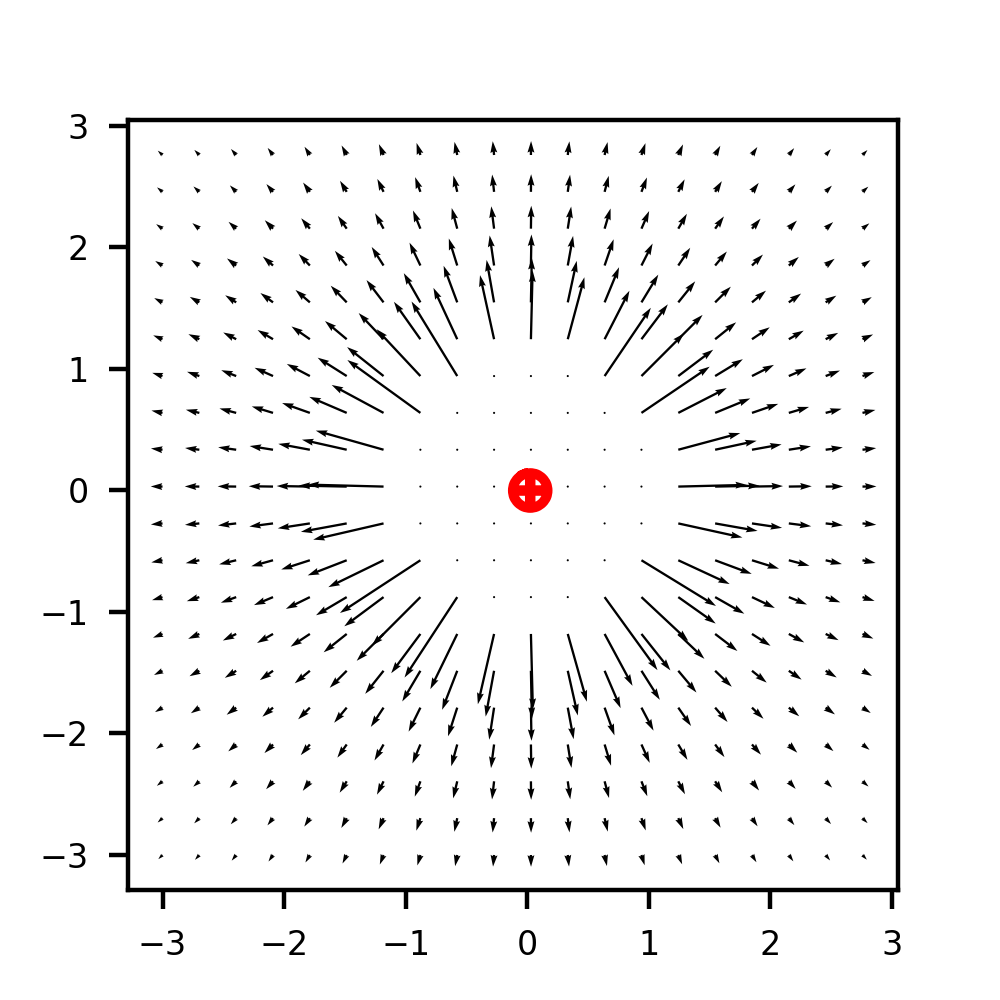

Button(description=u'Berechne Feld!', style=ButtonStyle())

HBox(children=(Checkbox(value=True, description=u'Feldvektoren'), Checkbox(value=False, description=u'Feldlinien'), Checkbox(value=False, description=u'Potential'), Checkbox(value=True, description=u'Quellen')))

Tab(children=(IntSlider(value=1, description=u'Ladung 1', max=20, min=-20), VBox(children=(HBox(children=(IntSlider(value=1, description=u'Ladung 1', max=20, min=-20), IntSlider(value=1, description=u'Ladung 2', max=20, min=-20))), FloatSlider(value=1.0, description=u'Distance', max=4.0, min=0.1))), HBox(children=(FloatSlider(value=1.0, description=u'Distance', max=4.0, min=0.1), IntSlider(value=1, description=u'Sources', max=50, min=1))), HBox(children=(FloatSlider(value=1.0, description=u'Distance', max=4.0, min=0.1), IntSlider(value=1, description=u'Sources', max=50, min=1)))), _titles={u'1': 'Zwei Ladungen', u'0': 'Einzelne Ladung', u'3': 'Hohlkreis', u'2': 'Dipol/Kondensator'})

8

In [13]:
#standard boilerplate for Python
%matplotlib notebook
import numpy as np
import matplotlib.pylab as plt
from ipywidgets import widgets
from IPython import display
from scipy.integrate import odeint
import time

np.seterr(divide='ignore', invalid='ignore')

w = 3
p = 100
vscale = 0.

fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
ax = fig.add_subplot(111)
fig.show()
mypos = []
k=[]

def onclick(event):
    global k, ax, mypos, vscale 
    if k != []:
        ax.lines.remove(k[0])
        k[1].remove()
        k[2].remove()
    k=plt.plot(event.xdata,event.ydata,marker='o',color='b',markersize=8)
    k.append(plt.text(event.xdata-0.16,event.ydata-0.16,'+',color='w',fontsize=10))#u"$\u2295$"
    mypos = [event.xdata,event.ydata]
    F = calc_force(mypos,0.)
    if (vscale == 0.):
        vscale = np.linalg.norm(F)
    F = F/vscale
    k.append(ax.arrow(mypos[0], mypos[1], F[0], F[1], head_width=0.05, head_length=0.1, fc='b', ec='b'))
    fig.canvas.draw()
    
def calc_force(pp,t):
    x=pp[0]
    y=pp[1]
    ex = 0
    ey = 0 
    for i in range(s_q.shape[0]):
        r1 = ((x-s_pos[i,0])**2+(y-s_pos[i,1])**2)**.5
        ex += s_q[i]*(x-s_pos[i,0])/r1**3
        ey += s_q[i]*(y-s_pos[i,1])/r1**3
    return [ex,ey]


def movepsource(event):
    global k, ax, mypos, s_pos, s_q, p, w
    
    nx = mypos[0]
    ny = mypos[1]
    dt = 0.03
    if k !=[]:
        y=odeint(calc_force,[nx, ny],np.linspace(0.,10.,100))
        
        for i in range(len(y)):
            l=plt.plot(y[i,0],y[i,1],'o')
            fig.canvas.draw()
            time.sleep(.005)
            ax.lines.remove(l[0])
            
              
def plotall(nv):
    global fig, ax, s_pos, s_q, k, vscale
    k = []
    vscale = 0.
    ex = np.zeros((p,p))
    ey = np.zeros((p,p))
    phi = np.zeros((p,p))
    yy, xx = np.mgrid[-w:w:p*1j, -w:w:p*1j]
    
    
    if tab.selected_index==0:
        s_q = np.array([float(w_strength1.value)])
        x_pos = np.zeros(1)
        y_pos = np.zeros(1)
        s_pos = np.transpose([x_pos,y_pos])
        N=1
    if tab.selected_index==1:
        s_q = np.array([float(w_strength1.value),float(w_strength2.value)])
        x_pos = np.array([0.,0.])
        y_pos = np.array([w_distance.value/2.,-w_distance.value/2.])
        s_pos = np.transpose([x_pos,y_pos])
        N=2       
    if tab.selected_index==2:
        #two lines 
        N = int(w_nsources.value) #number or source per line
        d = w_distance.value #distance between the lines
        if (N == 1):
            x_pos = np.array([0.])
        else:
            x_pos = np.linspace(-2.,2,N)
        x_pos = np.append(x_pos,x_pos)         
        y_pos = d/2.*np.ones(N)
        y_pos = np.append(y_pos,-y_pos)
        s_pos = np.transpose([x_pos,y_pos])
        s_q = np.append(np.ones(N),-np.ones(N))
        N=N*2
    if tab.selected_index==3:
        aphi=np.linspace(0.,np.pi*2.,100,endpoint=False)
        s_q = np.ones(100)
        x_pos = 1.*np.cos(aphi)
        y_pos = 1.*np.sin(aphi)
        s_pos = np.transpose([x_pos,y_pos])
        N=100       

        
    #calculate electric field
    for i in range(np.size(s_q)):
        r1 = ((xx-s_pos[i,0])**2+(yy-s_pos[i,1])**2)**.5
        ex += s_q[i]*(xx-s_pos[i,0])/r1**3
        ey += s_q[i]*(yy-s_pos[i,1])/r1**3
        phi += s_q[i]/r1
   
    tN=int(np.sum(np.abs(s_q))) #total abs charge 
    if tN<1:
        tN=1
        
    #electric field strength    
    eabs = np.sqrt(ex*ex + ey*ey)
    
    ax.clear()
    if w_fieldlines.value:
        ax.streamplot(xx, yy, ex, ey, color=np.log(eabs), density=1.5, linewidth=1, cmap=plt.cm.inferno, arrowstyle='->', arrowsize=1.)
    
    if w_sources.value:
        for i in range(N):
            if s_q[i] > 0:
                ax.plot(x_pos[i],y_pos[i],marker=u"$\u2295$",markersize=8,color='r')
            if s_q[i] < 0:
                ax.plot(x_pos[i],y_pos[i],marker=u"$\u2296$",markersize=8,color='b')
    
    if w_potential.value:
        ax.contour(xx,yy,phi,np.linspace(-tN,tN,20), linewidths = 2, cmap='RdBu_r')
        ax.contour(xx,yy,phi,np.linspace(-tN,tN,20), linewidths = .3, colors='k')
    
    if w_arrows.value:
        lv= np.where((ex**2+ey**2)>np.sum(np.abs(s_q))**2.)
        ex[lv]=0.
        ey[lv]=0.
        ax.quiver(xx[::5,::5], yy[::5,::5], ex[::5,::5], ey[::5,::5])

    plt.axes().set_aspect('equal')
    ax.tick_params(labelsize=6)
    fig.canvas.draw()
    
w_run = widgets.Button(description='Berechne Feld!')
w_movepsource = widgets.Button(description='Bewege Probenladung')
w_strength1 = widgets.IntSlider(min=-20,max=20, value=1,description="Ladung 1")
w_strength2 = widgets.IntSlider(min=-20,max=20, value=1,description="Ladung 2")
w_nsources = widgets.IntSlider(min=1,max=50.,value=1,description='Sources')
w_distance = widgets.FloatSlider(min=.1,max=4.,value=1.,description='Distance')
w_arrows = widgets.Checkbox(description='Feldvektoren',margin=10,value=True)
w_fieldlines = widgets.Checkbox(description='Feldlinien',margin=10,value=False)
w_potential = widgets.Checkbox(description='Potential',margin=10,value=False)
w_sources = widgets.Checkbox(description='Quellen',margin=10,value=True)
w_checks=widgets.HBox([w_arrows, w_fieldlines, w_potential, w_sources])
w_sliders=widgets.HBox([w_distance, w_nsources])
w_2charges=widgets.VBox([widgets.HBox([w_strength1, w_strength2]),w_distance])
config_tabs = ['Einzelne Ladung', 'Zwei Ladungen', 'Dipol/Kondensator', 'Hohlkreis']

children = [w_strength1, w_2charges, w_sliders, w_sliders]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, config_tabs[i])


w_run.on_click(plotall)
w_movepsource.on_click(movepsource)


display.display(w_run)
display.display(w_checks)
display.display(tab)



#display.display(w_movepsource)

plotall(1)
fig.canvas.mpl_connect('button_press_event', onclick)